# hydronetworks

This is a modified version of the [original code](https://github.com/carderne/hydronetworks) developed to make use of update **HydroRIVERS** data that now provide river segment connectivity, flow order and estimated discharge values for all river segments. 

**Original code:** [Chris Arderne](https://github.com/carderne) <br />
**Original Methodology:** [Korkovelos et al](https://www.mdpi.com/1996-1073/11/11/3100) <br />
**Updates, Modifications:** [Alexandros Korkovelos](https://github.com/akorkovelos) 

In [1]:
# Import necessary modules

from pathlib import Path
from hydronetworks import HydroNetworks
import matplotlib.pyplot as plt

%matplotlib inline

## Step 1. Specify paths, layers and projection system

**Necessary datasets**
* [HydroRIVERS](https://www.hydrosheds.org/page/hydrorivers)
* [Hydrologically conditioned elevation](https://www.hydrosheds.org/downloads)

**Optional datasets** (used only for visualization)
* [Administrative Boundaries](https://gadm.org/download_country_v3.html)

**Note!** In this example, **runoff (qmean)** and **flow accumulation (accflow)** datasets are not used since discharge values are already provided in HydroRIVERS. However, they are kept here in case needed for future development of the code. One can entirely omit in this version.

In [2]:
in_path = Path('input_data')
out_path = Path('output_data')

admin_path = in_path / "pastaza.gpkg"
rivers_path = in_path / 'HydroRIVERS_10v.gpkg'
dem_path = in_path / 'cond_dem.tif'

## Not needed in this version of the code
flow_path = in_path                         # in_path / 'qmean.tif'
flowacc_path = in_path                      # in_path / 'accflow.tif'

# Define projection system to be used in calculations, as suitable per case
sel_proj = 'epsg:24877'   # PSAD56 / UTM zone 17S for Pastaza province, Ecuador

## Step 2. Create instance and load layers

#### Create a hydronetwords instance

In [3]:
net = HydroNetworks(rivers_path=rivers_path,
                    dem_path=dem_path,
                    flow_path=flow_path,
                    flowacc_path=flowacc_path,
                    admin_path=admin_path,
                    sel_proj=sel_proj)

#### Load layers

In [4]:
net.load_files()

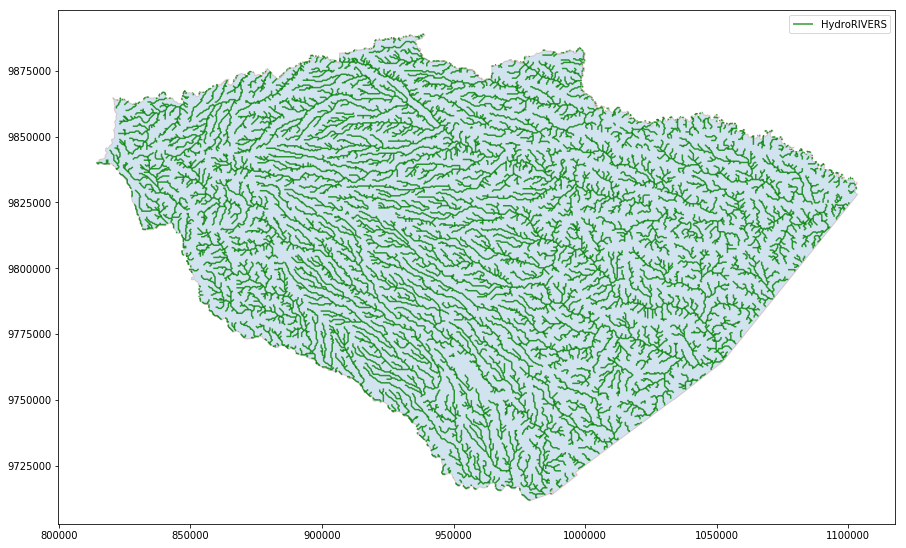

In [5]:
fig, ax = plt.subplots(figsize=(15, 15))
net.admin.plot(ax=ax, edgecolor='brown', alpha=0.2)
net.rivers.plot(ax=ax, color='green', edgecolor='none', figsize=(20, 20), alpha=0.8, label='HydroRIVERS')
ax.set_aspect('equal', 'box')
leg = ax.legend()
 
# Save plot as figure 
#plt.savefig('xxx.png', bbox_inches='tight')

DEM


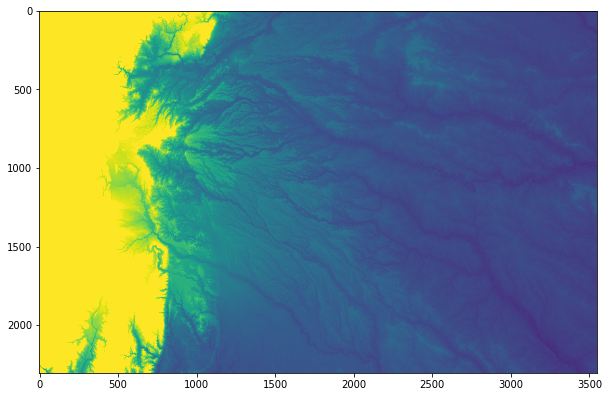

In [6]:
print('DEM')

fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(net.dem.read(1), vmin=0, vmax=1000)
ax.set_aspect('equal', 'box')
plt.show()  
# Save plot as figure 
#plt.savefig('xxx.png', bbox_inches='tight')

### Step 3. Process river network and run analysis

#### Keep rivers with Strahler number bigger than cut value (e.g. 3.0)

In [7]:
net.river_selection(3.0)

River network selected based on Strahler order


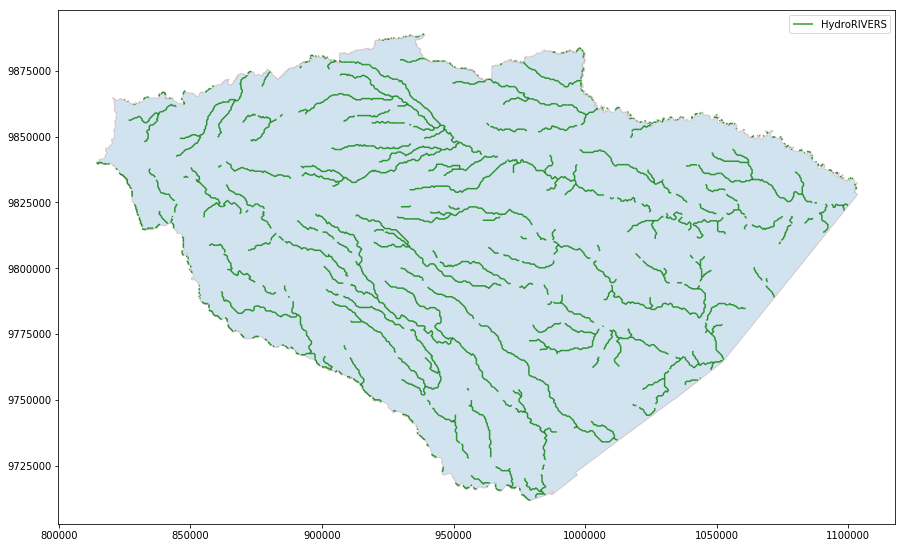

In [8]:
fig, ax = plt.subplots(figsize=(15, 15))
net.admin.plot(ax=ax, edgecolor='brown', alpha=0.2)
net.rivers.plot(ax=ax, color='green', edgecolor='none', figsize=(20, 20), alpha=0.8, label='HydroRIVERS')
ax.set_aspect('equal', 'box')
leg = ax.legend()
 
# Save plot as figure 
#plt.savefig('xxx.png', bbox_inches='tight')

#### Calculate hydro potential

In [9]:
net.calculate_hydro(interval=1000, head_distance=500, get_range=False)

Calculated hydro potential


#### Extract Mini & Small hydro potential

In [10]:
net.result_processor()

Results processed!


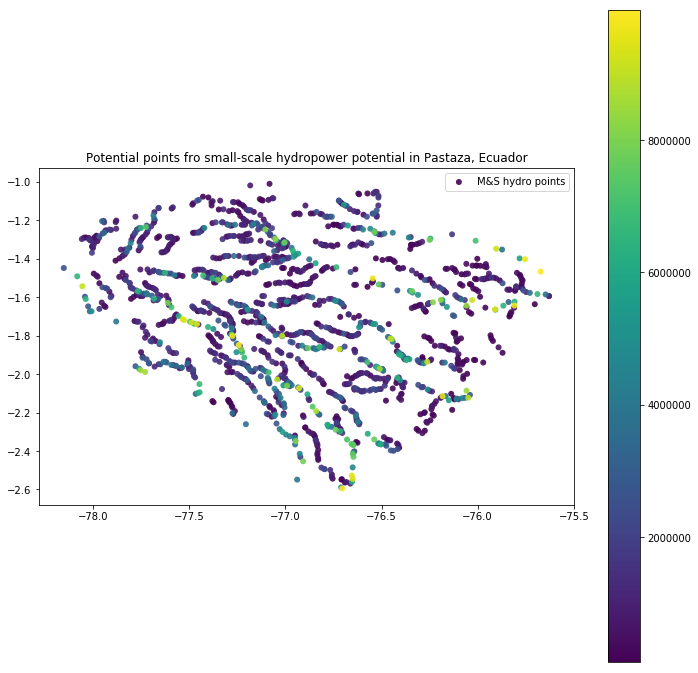

In [11]:
fig, ax = plt.subplots(figsize=(12, 12))
net.mini_and_small_hydro.sort_values('power', ascending=True).plot(ax=ax, column='power', legend=True, label='M&S hydro points', 
                                                                   edgecolor='none', figsize=(32,32), alpha=0.9)
ax.set_aspect('equal', 'box')
leg = ax.legend()
txt = ax.set_title('Potential points fro small-scale hydropower potential in Pastaza, Ecuador')

# Save plot as figure 
#plt.savefig('xxx.png', bbox_inches='tight')

#### Save results

* All hydro points identified
* Mini-hydro potential points
* Small-hydro potential points and 
* Both mini & small potential hydro points

In [12]:
net.save_results(out_path)